In [1]:
%run "Models training helpers.ipynb"

Using TensorFlow backend.
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

In [2]:
CONVENTION = "Green"
df = training_df[training_df['convention'] == CONVENTION]

In [3]:
## Checking performance setting validation data on the model training
## Validation data is created inside the models trainign function
conv_models = train_DL_models(df,
            data_class_column="convention", 
            data_label_column="label",
            df_val=None,
            tokenizer=extended_tokenizer,
            random_seed=0, 
            use_validation=True)

Found 86029 unique tokens.
----------------------------------------------------------------
            Green                  
----------------------------------------------------------------
Shape of data tensor: (160, 40)
Shape of label tensor: (160, 2)

Number of elements from each class in traing and validation set 
[73. 55.]
[18. 14.]







model fitting - more complex convolutional neural network
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 40)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 40, 100)      8603000     input_1[0][0]                    
________________________________________________________________________________

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=3)`
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=4)`
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=5)`


Train on 128 samples, validate on 32 samples
Epoch 1/20
128/128 [==============================] - 0s 3ms/step - loss: 2.5304 - acc: 0.5234 - val_loss: 1.0818 - val_acc: 0.4375
Roc-AUC on validation: 0.5992
Epoch 2/20
128/128 [==============================] - 0s 372us/step - loss: 0.7381 - acc: 0.6016 - val_loss: 0.6217 - val_acc: 0.5625
Roc-AUC on validation: 0.7302
Epoch 3/20
128/128 [==============================] - 0s 385us/step - loss: 0.5756 - acc: 0.7812 - val_loss: 0.6409 - val_acc: 0.6875
Roc-AUC on validation: 0.7659
Epoch 4/20
128/128 [==============================] - 0s 378us/step - loss: 0.5953 - acc: 0.6562 - val_loss: 0.7216 - val_acc: 0.5625
Roc-AUC on validation: 0.7659
Epoch 5/20
128/128 [==============================] - 0s 386us/step - loss: 0.5094 - acc: 0.7813 - val_loss: 0.5556 - val_acc: 0.6875
Roc-AUC on validation: 0.8254
Epoch 6/20
128/128 [==============================] - 0s 399us/step - loss: 0.4387 - acc: 0.8516 - val_loss: 0.8944 - val_acc: 0.5625
Roc

In [4]:
## Checking performance setting validation data on the model training
## Validation data is created outside the models trainign function
## Training models
texts = df['text'].values
labels = df['label'].values

indices = np.arange(len(texts))
np.random.seed(0)
np.random.shuffle(indices)
texts = texts[indices]
labels = labels[indices]
nb_validation_samples = int(VALIDATION_SPLIT * len(texts))

x_train = texts[:-nb_validation_samples]
y_train = labels[:-nb_validation_samples]
x_val = texts[-nb_validation_samples:]
y_val = labels[-nb_validation_samples:]

df_train = pd.DataFrame(columns=['text', 'label', 'convention'])
df_train['text'] = x_train
df_train['label'] = y_train
df_train['convention'] = CONVENTION


df_val = pd.DataFrame(columns=['text', 'label', 'convention'])
df_val['text'] = x_val
df_val['label'] = y_val
df_val['convention'] = CONVENTION

print("\n\n===========================")
print("WITH VALIDATION!")
print("===========================\n\n")
models2 = train_DL_models(df_train,
                data_class_column="convention", 
                data_label_column="label",
                df_val=df_val,
                tokenizer=extended_tokenizer,
                random_seed=0, use_validation=True)




WITH VALIDATION!


Found 86029 unique tokens.
----------------------------------------------------------------
            Green                  
----------------------------------------------------------------

Number of elements from each class in traing and validation set 
[73. 55.]
[18. 14.]


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=3)`
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=4)`
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=5)`


model fitting - more complex convolutional neural network
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 40)           0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 40, 100)      8603000     input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_5 (Conv1D)               (None, 38, 128)      38528       embedding_2[0][0]                
__________________________________________________________________________________________________
conv1d_6 (Conv1D)               (None, 37, 128)      51328       embedding_2[0][0]                
__________________________________

In [5]:
######################
### Cross validation
######################

## 1. Split training, validation data outside the training function
## 2. Train a model with training data
## 3. Check performance (acc) of the model on training and validation
## 4. Repeat num_tests times
## Next cell plots results

## Number of tests = 10
num_tests = 10
num_epochs = 20

accs = []
val_accs = []
epochs = np.arange(0,num_epochs, 1)

texts = df['text'].values
labels = df['label'].values


for n in range(num_tests):
    print("\n\n=================================")
    print("               {}".format(n))
    print("=================================")
    indices = np.arange(len(texts))
    np.random.seed(0)
    np.random.shuffle(indices)
    texts = texts[indices]
    labels = labels[indices]
    nb_validation_samples = int(VALIDATION_SPLIT * len(texts))

    x_train = texts[:-nb_validation_samples]
    y_train = labels[:-nb_validation_samples]
    x_val = texts[-nb_validation_samples:]
    y_val = labels[-nb_validation_samples:]

    df_train = pd.DataFrame(columns=['text', 'label', 'convention'])
    df_train['text'] = x_train
    df_train['label'] = y_train
    df_train['convention'] = CONVENTION


    df_val = pd.DataFrame(columns=['text', 'label', 'convention'])
    df_val['text'] = x_val
    df_val['label'] = y_val
    df_val['convention'] = CONVENTION


    tmp_training = train_DL_models(df_train,
                data_class_column="convention", 
                data_label_column="label",
                df_val=df_val,
                tokenizer=extended_tokenizer,
                random_seed=0,
                use_validation=True, 
                num_epochs = num_epochs)

    accs.append(tmp_training[4][CONVENTION].history['acc'])
    val_accs.append(tmp_training[4][CONVENTION].history['val_acc'])       




               0
Found 86029 unique tokens.
----------------------------------------------------------------
            Green                  
----------------------------------------------------------------

Number of elements from each class in traing and validation set 
[73. 55.]
[18. 14.]


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=3)`
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=4)`
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=5)`


model fitting - more complex convolutional neural network
Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 40)           0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 40, 100)      8603000     input_3[0][0]                    
__________________________________________________________________________________________________
conv1d_9 (Conv1D)               (None, 38, 128)      38528       embedding_3[0][0]                
__________________________________________________________________________________________________
conv1d_10 (Conv1D)              (None, 37, 128)      51328       embedding_3[0][0]                
__________________________________

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=3)`
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=4)`
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=5)`


model fitting - more complex convolutional neural network
Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 40)           0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 40, 100)      8603000     input_4[0][0]                    
__________________________________________________________________________________________________
conv1d_13 (Conv1D)              (None, 38, 128)      38528       embedding_4[0][0]                
__________________________________________________________________________________________________
conv1d_14 (Conv1D)              (None, 37, 128)      51328       embedding_4[0][0]                
__________________________________

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=3)`
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=4)`
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=5)`


model fitting - more complex convolutional neural network
Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 40)           0                                            
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 40, 100)      8603000     input_5[0][0]                    
__________________________________________________________________________________________________
conv1d_17 (Conv1D)              (None, 38, 128)      38528       embedding_5[0][0]                
__________________________________________________________________________________________________
conv1d_18 (Conv1D)              (None, 37, 128)      51328       embedding_5[0][0]                
__________________________________

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=3)`
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=4)`
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=5)`


model fitting - more complex convolutional neural network
Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 40)           0                                            
__________________________________________________________________________________________________
embedding_6 (Embedding)         (None, 40, 100)      8603000     input_6[0][0]                    
__________________________________________________________________________________________________
conv1d_21 (Conv1D)              (None, 38, 128)      38528       embedding_6[0][0]                
__________________________________________________________________________________________________
conv1d_22 (Conv1D)              (None, 37, 128)      51328       embedding_6[0][0]                
__________________________________

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=3)`
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=4)`
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=5)`


model fitting - more complex convolutional neural network
Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 40)           0                                            
__________________________________________________________________________________________________
embedding_7 (Embedding)         (None, 40, 100)      8603000     input_7[0][0]                    
__________________________________________________________________________________________________
conv1d_25 (Conv1D)              (None, 38, 128)      38528       embedding_7[0][0]                
__________________________________________________________________________________________________
conv1d_26 (Conv1D)              (None, 37, 128)      51328       embedding_7[0][0]                
__________________________________

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=3)`
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=4)`
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=5)`


model fitting - more complex convolutional neural network
Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            (None, 40)           0                                            
__________________________________________________________________________________________________
embedding_8 (Embedding)         (None, 40, 100)      8603000     input_8[0][0]                    
__________________________________________________________________________________________________
conv1d_29 (Conv1D)              (None, 38, 128)      38528       embedding_8[0][0]                
__________________________________________________________________________________________________
conv1d_30 (Conv1D)              (None, 37, 128)      51328       embedding_8[0][0]                
__________________________________

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=3)`
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=4)`
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=5)`


model fitting - more complex convolutional neural network
Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 40)           0                                            
__________________________________________________________________________________________________
embedding_9 (Embedding)         (None, 40, 100)      8603000     input_9[0][0]                    
__________________________________________________________________________________________________
conv1d_33 (Conv1D)              (None, 38, 128)      38528       embedding_9[0][0]                
__________________________________________________________________________________________________
conv1d_34 (Conv1D)              (None, 37, 128)      51328       embedding_9[0][0]                
__________________________________

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=3)`
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=4)`
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=5)`


model fitting - more complex convolutional neural network
Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           (None, 40)           0                                            
__________________________________________________________________________________________________
embedding_10 (Embedding)        (None, 40, 100)      8603000     input_10[0][0]                   
__________________________________________________________________________________________________
conv1d_37 (Conv1D)              (None, 38, 128)      38528       embedding_10[0][0]               
__________________________________________________________________________________________________
conv1d_38 (Conv1D)              (None, 37, 128)      51328       embedding_10[0][0]               
_________________________________

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=3)`
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=4)`
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=5)`


model fitting - more complex convolutional neural network
Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 40)           0                                            
__________________________________________________________________________________________________
embedding_11 (Embedding)        (None, 40, 100)      8603000     input_11[0][0]                   
__________________________________________________________________________________________________
conv1d_41 (Conv1D)              (None, 38, 128)      38528       embedding_11[0][0]               
__________________________________________________________________________________________________
conv1d_42 (Conv1D)              (None, 37, 128)      51328       embedding_11[0][0]               
_________________________________

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=3)`
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=4)`
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=5)`


model fitting - more complex convolutional neural network
Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           (None, 40)           0                                            
__________________________________________________________________________________________________
embedding_12 (Embedding)        (None, 40, 100)      8603000     input_12[0][0]                   
__________________________________________________________________________________________________
conv1d_45 (Conv1D)              (None, 38, 128)      38528       embedding_12[0][0]               
__________________________________________________________________________________________________
conv1d_46 (Conv1D)              (None, 37, 128)      51328       embedding_12[0][0]               
_________________________________

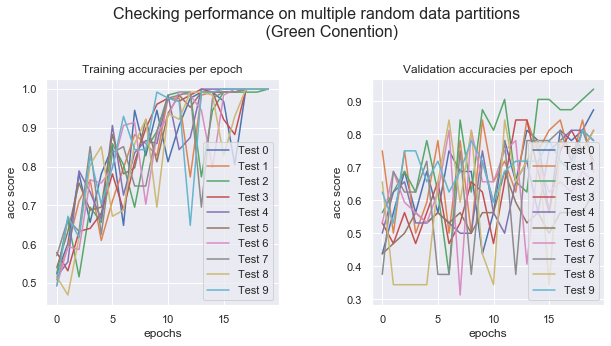

In [6]:
fig = plt.figure(figsize=[10,10])
fig.suptitle("Checking performance on multiple random data partitions\n       ({} Conention)".format(CONVENTION), fontsize=16)
plt.subplot(2, 2, 1)
plt.subplots_adjust(wspace=0.4, hspace=0.4)


for i in range(len(accs)):
    plt.plot(epochs,accs[i], label="Test {}".format(i))
plt.title("Training accuracies per epoch")
plt.xlabel("epochs")
plt.ylabel("acc score")
plt.legend()

plt.subplot(2, 2, 2)
for i in range(len(val_accs)):
    plt.plot(epochs,val_accs[i], label="Test {}".format(i))
plt.title("Validation accuracies per epoch")
plt.xlabel("epochs")
plt.ylabel("acc score")
plt.legend()
plt.show()

In [7]:
models2_tokenizer = models2[1][CONVENTION]
val_seq = models2_tokenizer.texts_to_sequences(x_val)
val_seq = pad_sequences(val_seq, maxlen=MAX_SEQUENCE_LENGTH)

preds2 = models2[0][CONVENTION].predict(val_seq)
print("Real label for samples classified with value 0")
display(y_val[preds2[:,0]>preds2[:,1]])
print("Real label for samples classified with value 1")
display(y_val[preds2[:,0]<preds2[:,1]])

Real label for samples classified with value 0


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0])

Real label for samples classified with value 1


array([1, 1, 1, 1, 1, 1, 1, 1, 1])

In [8]:

print("\n\n===========================")    
print("WITHOUT VALIDATION!")
print("===========================\n\n")
models3 = train_DL_models(df_train,
                data_class_column="convention", 
                data_label_column="label",
                df_val=None,
                tokenizer = models2_tokenizer,
                random_seed=0, use_validation=False)




WITHOUT VALIDATION!


Found 86029 unique tokens.
----------------------------------------------------------------
            Green                  
----------------------------------------------------------------
Shape of data tensor: (128, 40)
Shape of label tensor: (128, 2)

Number of elements from each class in traing and validation set 
[69. 59.]
10


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=3)`
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=4)`
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=5)`


model fitting - more complex convolutional neural network
Model: "model_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           (None, 40)           0                                            
__________________________________________________________________________________________________
embedding_13 (Embedding)        (None, 40, 100)      8603000     input_13[0][0]                   
__________________________________________________________________________________________________
conv1d_49 (Conv1D)              (None, 38, 128)      38528       embedding_13[0][0]               
__________________________________________________________________________________________________
conv1d_50 (Conv1D)              (None, 37, 128)      51328       embedding_13[0][0]               
_________________________________

In [9]:
if not imported_notebook:
    val_seq = models2_tokenizer.texts_to_sequences(x_val)
    val_seq = pad_sequences(val_seq, maxlen=MAX_SEQUENCE_LENGTH)

    preds2 = models2[0][CONVENTION].predict(val_seq)
    print("Real label for samples classified with value 0")
    display(y_val[preds2[:,0]>preds2[:,1]])
    print("Real label for samples classified with value 1")
    display(y_val[preds2[:,0]<preds2[:,1]])

In [10]:
if not imported_notebook:
    tok1 = create_tokenizer(training_df)
    word_index = tok1.word_index
    tok1_words = []
    for word, i in word_index.items():
        tok1_words.append(word)
        
    for idx, _df in enumerate(gathered_dfs[:-1]):
        tok2 = create_tokenizer(_df)
        word_index2 = tok2.word_index
        
        gathered_f = gathered_data_files[idx]
        
        tok2_words = []
        for word, i in word_index2.items():
            tok2_words.append(word)
            
        words_in_tok1 = [w for w in tok2_words if w in tok1_words]
        tok1_words_in_tok2 = [w for w in tok1_words if w in tok2_words]
        print("\n > {}".format(gathered_f))
        print("Gathered source words in training data: {}".format(len(words_in_tok1) / len(tok1_words)))
        print("Training data words in gathered source: {}".format(len(tok1_words_in_tok2) / len(tok2_words)))
              

In [11]:

NUM_SENTENCES_TO_SHOW=10

df_test = pd.read_csv(os.path.join(GATHERED_DATA_FOLDER, "gathered_github_sentences.tsv"), sep="\t")

test_sentences = df_test['sentence'].values

test_seq = extended_tokenizer.texts_to_sequences(test_sentences)
test_seq = pad_sequences(val_seq, maxlen=MAX_SEQUENCE_LENGTH)

preds = conv_models[0][CONVENTION].predict(test_seq)[:,1]

print("-----------------------------------------------------")
print(" >> Top sentences with higher confidence for Github:")
print("            ({} convention)".format(CONVENTION))
print("-----------------------------------------------------\n")
for s in test_sentences[preds.argsort()[-NUM_SENTENCES_TO_SHOW:][::-1]]:
    print("{}\n".format(s))
    
    

-----------------------------------------------------
 >> Top sentences with higher confidence for Github:
            (Green convention)
-----------------------------------------------------

why introductory programmingbuild a modern computer from first principles from nand to tetris alt 6 weeks 7-13 hours week - c-like programming languagebuild a modern computer from first principles nand to tetris part ii 6 weeks 12-18 hours week - one of these programming languages, from nand to tetris part iintroduction to computer networking 8 weeks 4 12 hours week assignment 1assignment 2assignment 3assignment 4 algebra, probability, basic csops-class.org - hack the kernel 15 weeks 6 hours week replace course textbook with operating systems three easy pieces algorithms core theorytopics covered divide and conquer sorting and searching randomized algorithms graph search shortest paths data structures greedy algorithms minimum spanning trees dynamic programming np-completeness and morecourses dur